# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

This notebook details the specifications of my final capstone project for IBM Applied Data Science
Capstone course in Coursera.
For this project, I’m going to use the Foursquare location data and machine learning tools in order
to segment and cluster neighborhoods in Athens, Greece.
Being a fan of both Italian food and the grandiose Greek capital, I chose to setup a tool that
helps an Italian restaurateur to open an Italian restaurant in Athens. Since Italian food is very
spread worldwide, it is quite common to come across a Neapolitan or Sicilian restaurant in any
neighborhood or city. Therefore finding the most suitable location to open such a restaurant is one
of the most important decisions for this entrepreneur as a good location is one of the pillars of a
profitable business.

## Data <a name="data"></a>

The first step of building the tool would be naturally to specify the data we’re going to need and
then collect it from the adequate sources.

In order to be able to cluster the neighborhoods of Athens we need:
* List of neighborhoods in Athens: It is necessary to collect the neighborhoods of the city of
Athens to apply the clustering.
* Latitude and Longitude of the neighborhoods: We need the geolocation coordinates of each
neighborhood in order to extract the venues located in each one.
* Venues: Finally we need to extract the list of Italian restaurants along with different types of attraction venues in each neighborhood to complete our data collection. For the first step of data collection, we will load all sort of venues provided by Foursquare, then we will filter the places with the types we desire.

We used the following data sources to collect the features specified above:
* List of neighborhoods in Athens: This part is collected from (https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Athens) 
* Latitude and Longitude of the neighborhoods: The coordinates are extracted via geopy.geocoders python package.
* Venues: The venues and their attributes are provided by the Foursquare API.

In [2]:
# import requests and BeautifulSoup to parse the wikipedia page
from bs4 import BeautifulSoup
import requests

import pandas as pd
import numpy as np

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium

The next step would be to get the page content and store it in a BeautifulSoup object.

Note that i used **lxml** as the html processing library.

In [3]:
# wikipedia page link
url = 'https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Athens'

# get the html source code of the postal codes page
html_source = requests.get(url).text

# create a BeautifulSoup object to parse the html code
soup_page = BeautifulSoup(html_source,'lxml')

In this section, we will parse the BeautifulSoup object, grab the html list and convert it into a dataframe:

In [4]:
# parse the object to grab the html table

columns = ['Neighborhood']

athens_neighborhoods = pd.DataFrame(columns=columns)

list = soup_page.find('div', class_='mw-body').find('div',id='bodyContent').find('div',id='mw-content-text').find('div',class_='mw-category-generated').find('div',id='mw-pages').find('div',class_='mw-content-ltr').find('div',class_='mw-category').find_all('div')
for item in list:
    for list_item in item.ul.find_all('li'):
        neighborhood = str(list_item.text).split(',')[0]
        athens_neighborhoods=athens_neighborhoods.append({'Neighborhood': neighborhood}, ignore_index=True)

athens_neighborhoods = athens_neighborhoods.iloc[:-1,]


In [5]:
athens_neighborhoods.head()

,Neighborhood
0,Aerides
1,Agios Eleftherios
2,Agios Panteleimonas
3,Akadimia Platonos
4,Akadimia


Now we need to collect the coordinates of the neighborhoods we collected:

In [6]:
geolocator = Nominatim(user_agent="ny_explorer")

for neighborhood in athens_neighborhoods['Neighborhood']:
    try:
        address = neighborhood+', Greece'
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        index =  athens_neighborhoods.index[athens_neighborhoods['Neighborhood'] == neighborhood]
        athens_neighborhoods.loc[index,'Latitude']= latitude
        athens_neighborhoods.loc[index,'Longitude']= longitude

    except:
        pass

print('----------')
print('Done!')
print('----------')

----------
Done!
----------


In [9]:
athens_neighborhoods.head(10)

,Neighborhood,Latitude,Longitude
0,Aerides,36.147765,22.989737
1,Agios Eleftherios,38.020044,23.731724
2,Agios Panteleimonas,37.607478,26.096458
3,Akadimia Platonos,37.989357,23.711217
4,Akadimia,37.980285,23.734528
5,Ampelokipoi,37.758008,20.871949
6,Anafiotika,37.972351,23.728043
7,Ano Petralona,NaN,NaN
8,Asteroskopeio,37.973125,23.719985
9,Asyrmatos,NaN,NaN


As we can see above, we need to clean the data since we couldn't extract the cooridnates of some of the neighborhoods, there fore we must drop all the rows with empty coordinates.

In [10]:
athens_neighborhoods=athens_neighborhoods.dropna()
athens_neighborhoods.head(10)

,Neighborhood,Latitude,Longitude
0,Aerides,36.147765,22.989737
1,Agios Eleftherios,38.020044,23.731724
2,Agios Panteleimonas,37.607478,26.096458
3,Akadimia Platonos,37.989357,23.711217
4,Akadimia,37.980285,23.734528
5,Ampelokipoi,37.758008,20.871949
6,Anafiotika,37.972351,23.728043
8,Asteroskopeio,37.973125,23.719985
10,Attiki,38.059883,23.758686
11,Elaionas,38.198813,22.169811


Let's check how many neighborhood did we end up with:

In [11]:
print('----------------------------------------')
print('Number of neighborhoods to cluster: {}'.format(athens_neighborhoods.shape[0]))
print('----------------------------------------')

----------------------------------------
Number of neighborhoods to cluster: 51
----------------------------------------


Let's create a map to visualize the data we cleaned:

In [12]:
address = 'Athens, Greece'

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_Athens = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(athens_neighborhoods['Latitude'], athens_neighborhoods['Longitude'], athens_neighborhoods['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Athens)  
    
map_Athens

### Foursquare API
Now that we have our location candidates, let's use Foursquare API to collect all the venues in each neighborhood.

After we get the venues from the API, we need to filter them and keep Italian restaurants and attractions.

In [13]:
CLIENT_ID = '3MI4THPNW3SDCZDZDDCNX4VBK31BMZGMZNWI2XDTFPENXW2I'
CLIENT_SECRET = 'R4EQZH5YSOHSKJGBZLRWV4SVXCAALGUREUWMWPBNFW0YSA1E'
VERSION = '20180605' # Foursquare API version

LIMIT= 100

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
athens_venues = getNearbyVenues(names=athens_neighborhoods['Neighborhood'],
                                   latitudes=athens_neighborhoods['Latitude'],
                                   longitudes=athens_neighborhoods['Longitude']
                                  )
print('----------')
print('Done!')
print('----------')

----------
Done!
----------


In [16]:
athens_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aerides,36.147765,22.989737,Fossa,36.148441,22.988234,Café
1,Aerides,36.147765,22.989737,Κάστρο Χώρας,36.147039,22.990399,Castle
2,Aerides,36.147765,22.989737,Mercato,36.148107,22.988716,Bar
3,Aerides,36.147765,22.989737,Κούκος,36.147208,22.992778,Bar
4,Aerides,36.147765,22.989737,choraki,36.148251,22.988503,Cocktail Bar


Now we need to clean the data and keep the venues we need:

In [17]:
attractions=['Art Gallery','Concert Hall','Movie Theater','Music Venue','Museum','Pub','Performing Arts Venue']
attraction_venues = athens_venues[athens_venues['Venue Category'].isin(attractions)].reset_index(drop=True)

attraction_venues_index = pd.get_dummies(attraction_venues[['Venue Category']], prefix="", prefix_sep="")
attraction_venues_index['Neighborhood'] = attraction_venues['Neighborhood']

columns = attraction_venues_index.columns.tolist()
columns = columns[-1:] + columns[:-1]
attraction_venues_index = attraction_venues_index[columns]

number_attractions = pd.DataFrame(data=attraction_venues_index.groupby('Neighborhood').size()).reset_index()
number_attractions.columns=['Neighborhood','Number of attractions']

number_attractions = number_attractions.merge(athens_neighborhoods,how='right',on='Neighborhood').fillna(0)
number_attractions = number_attractions[['Neighborhood','Number of attractions']]
number_attractions.head()

,Neighborhood,Number of attractions
0,Akadimia,1.0
1,Akadimia Platonos,1.0
2,Anafiotika,2.0
3,Asteroskopeio,3.0
4,Ellinoroson,1.0


We also need to count the number of italian restaurants per neighborhood:

In [18]:
# one hot encoding
italian= athens_venues[athens_venues['Venue Category']=='Italian Restaurant'].reset_index(drop=True)
italian_venues = pd.get_dummies(italian[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
italian_venues['Neighborhood'] = italian['Neighborhood']
fixed_columns = italian_venues.columns.tolist()
fixed_columns =fixed_columns[-1:] + fixed_columns[:-1]
italian_venues = italian_venues[fixed_columns]
italian_grouped = italian_venues.groupby('Neighborhood').sum().reset_index()
italian_grouped.columns=['Neighborhood', 'Number of Italian Restaurants']

italian_grouped = italian_grouped.merge(athens_neighborhoods,how='right',on='Neighborhood').fillna(0)
italian_grouped = italian_grouped[['Neighborhood','Number of Italian Restaurants']]

italian_grouped.head()

,Neighborhood,Number of Italian Restaurants
0,Aerides,1.0
1,Akadimia,1.0
2,Ellinoroson,2.0
3,Kallimarmaro,6.0
4,Kallimarmaro,6.0


Now merging the 2 dataframes we created to form the final list we're going to cluster:

In [19]:
final_neighborhoods = italian_grouped.merge(number_attractions,how='inner',on='Neighborhood').fillna(0).drop_duplicates().reset_index(drop=True)
final_neighborhoods.head()

,Neighborhood,Number of Italian Restaurants,Number of attractions
0,Aerides,1.0,0.0
1,Akadimia,1.0,1.0
2,Ellinoroson,2.0,1.0
3,Kallimarmaro,6.0,2.0
4,Kolonaki,4.0,2.0


Let's visualize the data we cleaned and prepared:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94c557b750>]],
      dtype=object)

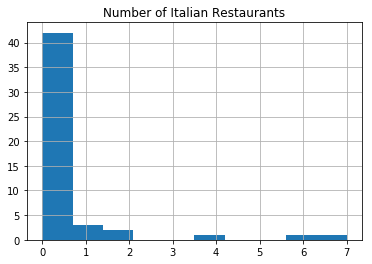

In [26]:
hist=final_neighborhoods.copy()
hist.set_index('Neighborhood',inplace=True)

hist.hist(column='Number of Italian Restaurants',bins=10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94c5647610>]],
      dtype=object)

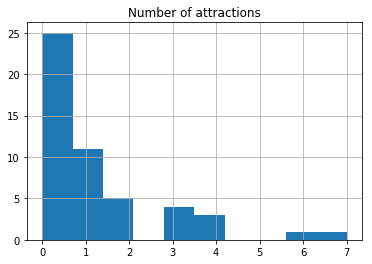

In [25]:
hist.hist(column='Number of attractions',bins=10)

## Clustering

The final part would be to apply Kmeans in order to cluster the neighborhoods based on the features we calculated:
* Number of attractions per neighborhood
* Number of italian restaurants per neighborhood

In [27]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 3

italian_grouped_clustering = final_neighborhoods.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(italian_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 2, 2, 1, 2, 1, 1, 1], dtype=int32)

Let's add the generated cluster labels to the neighborhoods list in order to analyse the groups we obtained:

In [30]:
# add clustering labels
final_neighborhoods.insert(0, 'Cluster Labels', kmeans.labels_)

italian_restaurants = athens_neighborhoods

italian_restaurants = italian_restaurants.join(final_neighborhoods.set_index('Neighborhood'), on='Neighborhood', how='inner').reset_index(drop=True)

italian_restaurants.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,Number of Italian Restaurants,Number of attractions
0,Aerides,36.147765,22.989737,1,1.0,0.0
1,Agios Eleftherios,38.020044,23.731724,1,0.0,0.0
2,Agios Panteleimonas,37.607478,26.096458,1,0.0,0.0
3,Akadimia Platonos,37.989357,23.711217,1,0.0,1.0
4,Akadimia,37.980285,23.734528,1,1.0,1.0


Let's visualize the clustered neighborhoods on the map:

In [31]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(italian_restaurants['Latitude'], italian_restaurants['Longitude'], italian_restaurants['Neighborhood'], italian_restaurants['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In order to analyse the clusters we have, let's visualize histograms for each cluster:

,Latitude,Longitude,Cluster Labels,Number of Italian Restaurants,Number of attractions
Neighborhood,,,,,
Asteroskopeio,37.973125,23.719985,0,0.0,3.0
Kerameikos,37.978730,23.719506,0,0.0,3.0
Kountouriotika,37.985335,23.754196,0,0.0,4.0
Metaxourgeio,37.985853,23.721380,0,0.0,3.0
Monastiraki,37.976273,23.725929,0,0.0,3.0
Pedion tou Areos,40.622526,22.955472,0,0.0,4.0
Rouf,37.979114,23.713333,0,0.0,7.0
Thiseio,37.976766,23.720329,0,0.0,6.0


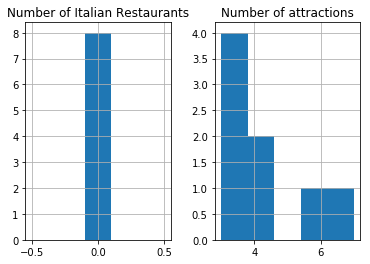

In [39]:
cluster_0=italian_restaurants.loc[italian_restaurants['Cluster Labels'] == 0.0, ].copy()
cluster_0.set_index('Neighborhood',inplace=True)

cluster_0.hist(column=['Number of Italian Restaurants','Number of attractions'],bins=5)
cluster_0

,Latitude,Longitude,Cluster Labels,Number of Italian Restaurants,Number of attractions
Neighborhood,,,,,
Aerides,36.147765,22.989737,1,1.0,0.0
Agios Eleftherios,38.020044,23.731724,1,0.0,0.0
Agios Panteleimonas,37.607478,26.096458,1,0.0,0.0
Akadimia Platonos,37.989357,23.711217,1,0.0,1.0
Akadimia,37.980285,23.734528,1,1.0,1.0


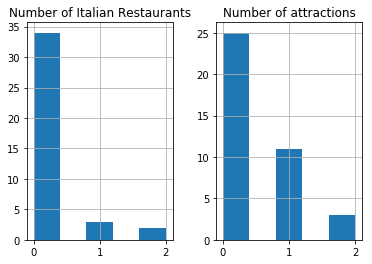

In [41]:
cluster_1=italian_restaurants.loc[italian_restaurants['Cluster Labels'] == 1.0, ].copy()
cluster_1.set_index('Neighborhood',inplace=True)

cluster_1.hist(column=['Number of Italian Restaurants','Number of attractions'],bins=5)
cluster_1.head()

,Latitude,Longitude,Cluster Labels,Number of Italian Restaurants,Number of attractions
Neighborhood,,,,,
Kallimarmaro,37.968424,23.740403,2,6.0,2.0
Kallimarmaro,37.968424,23.740403,2,6.0,2.0
Kolonaki,37.976975,23.740814,2,4.0,2.0
Mount Lycabettus,37.981886,23.743152,2,7.0,4.0


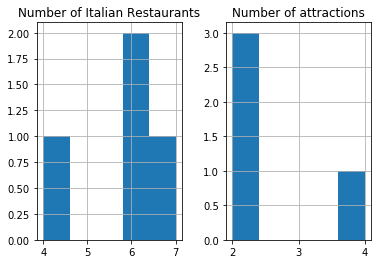

In [42]:
cluster_2=italian_restaurants.loc[italian_restaurants['Cluster Labels'] == 2.0, ].copy()
cluster_2.set_index('Neighborhood',inplace=True)

cluster_2.hist(column=['Number of Italian Restaurants','Number of attractions'],bins=5)
cluster_2.head()

## Conclusion

In conclusion, and based on the graphs shown above, we can clearly notice that we obtained 3 types of neighborhoods:
* Cluster 1: This cluster is characterized by a low number of italian restaurants (0) and a high number of attractions
* Cluster 2: This group is not characterized by the presence of italian restaurants nor attractions.
* Cluster 3: Finally, we have a group of neighborhoods that has a high number of italian restaurants but not a very high number of attractions.

Obviously, our Italian entrepreneur should consider the neighborhoods within cluster 1 to setup his business.